In [1]:
import os
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1] + ['memn2n']))
import torch
import numpy as np
from utils import Config, plot_result, decode, run_single_example
from train import import_data, build_model

In [11]:
weight_styles = ['adjacent', 'rnnlike']
other_methods = ['bow', 'pe_te']
config = Config(emd=20)
device = None
task = 1
rnd_idx = np.random.choice(1000)

In [12]:
def build_single_model(config, task, weight_style, other_method, device):
    map_location = {'cuda:0':'cpu'} if device is None else None
    load_path = config.build(task=task, weight_style=weight_style, other_method=other_method)
    test, _ = import_data(config, device, is_test=True)
    model, *_ = build_model(config, test.vocab, test.maxlen_story, device)
    model.load_state_dict(torch.load(load_path,  map_location=map_location))
    return test, model, load_path


**Weight sharing style**

* adajcent: output of the context($C_k$) embedding becomes input embedding of context($A_{k+1}$), $k$=hop
* rnnlike: input context embedding($A$) and output context embedding($C$) share their own embeddings


**Other Methods**

* BOW : bag of words
* PE : position encoding
* TE : temporal encoding

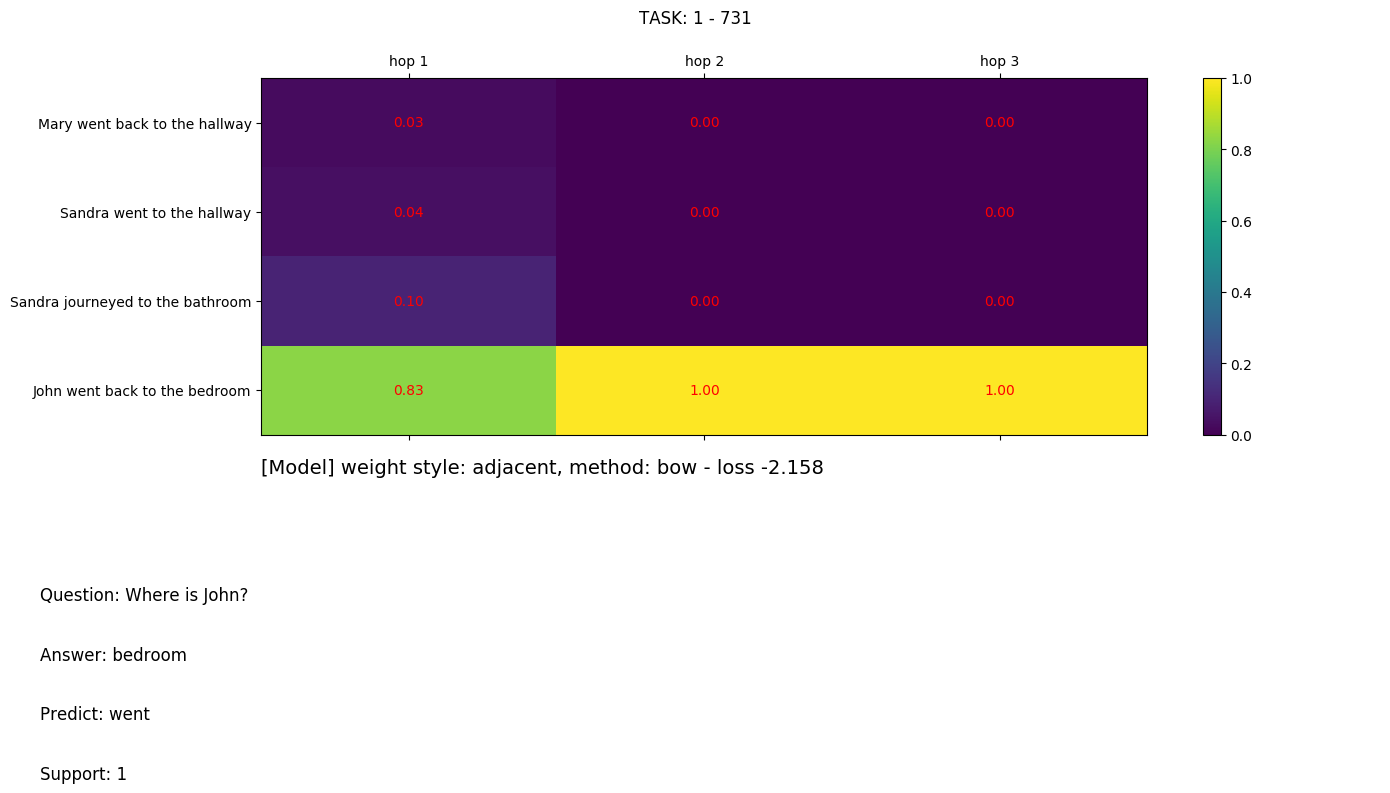

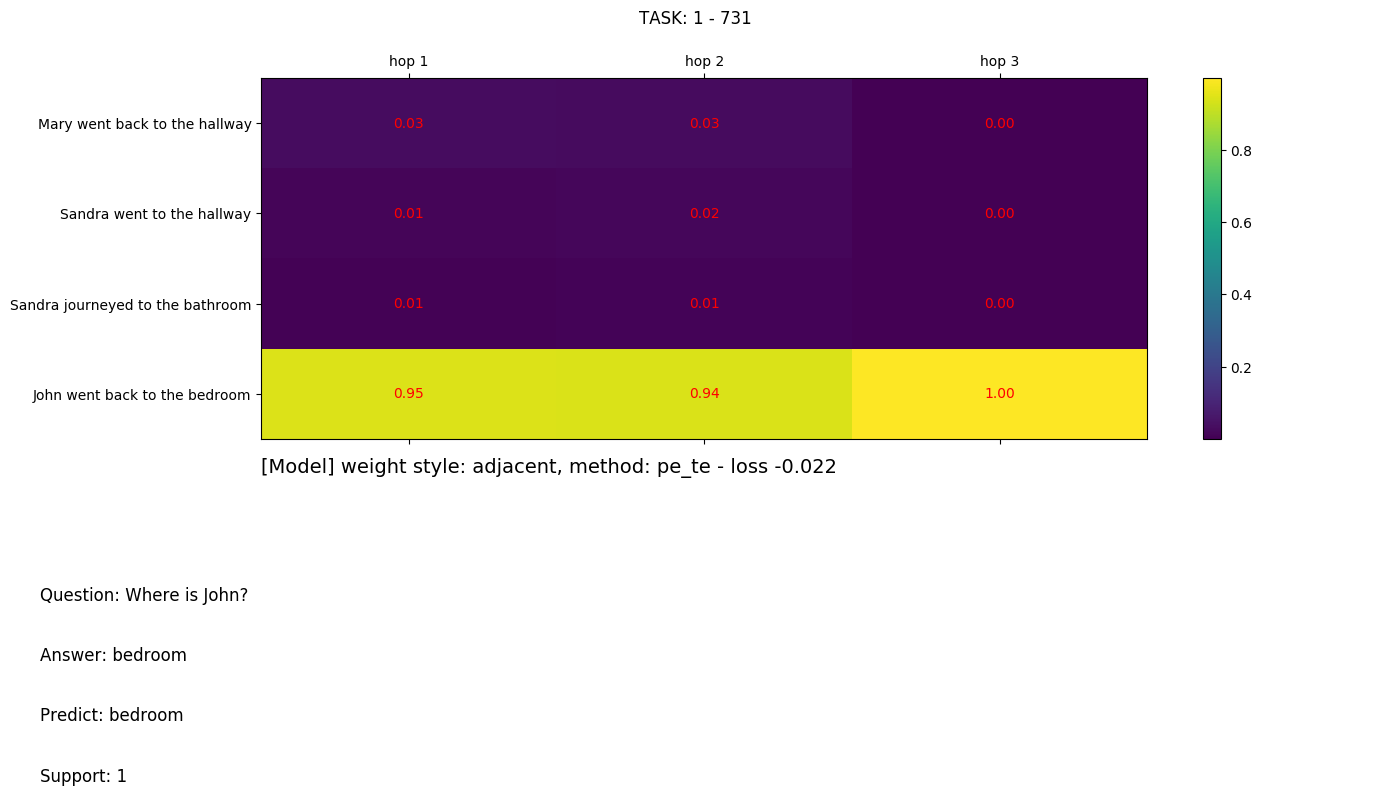

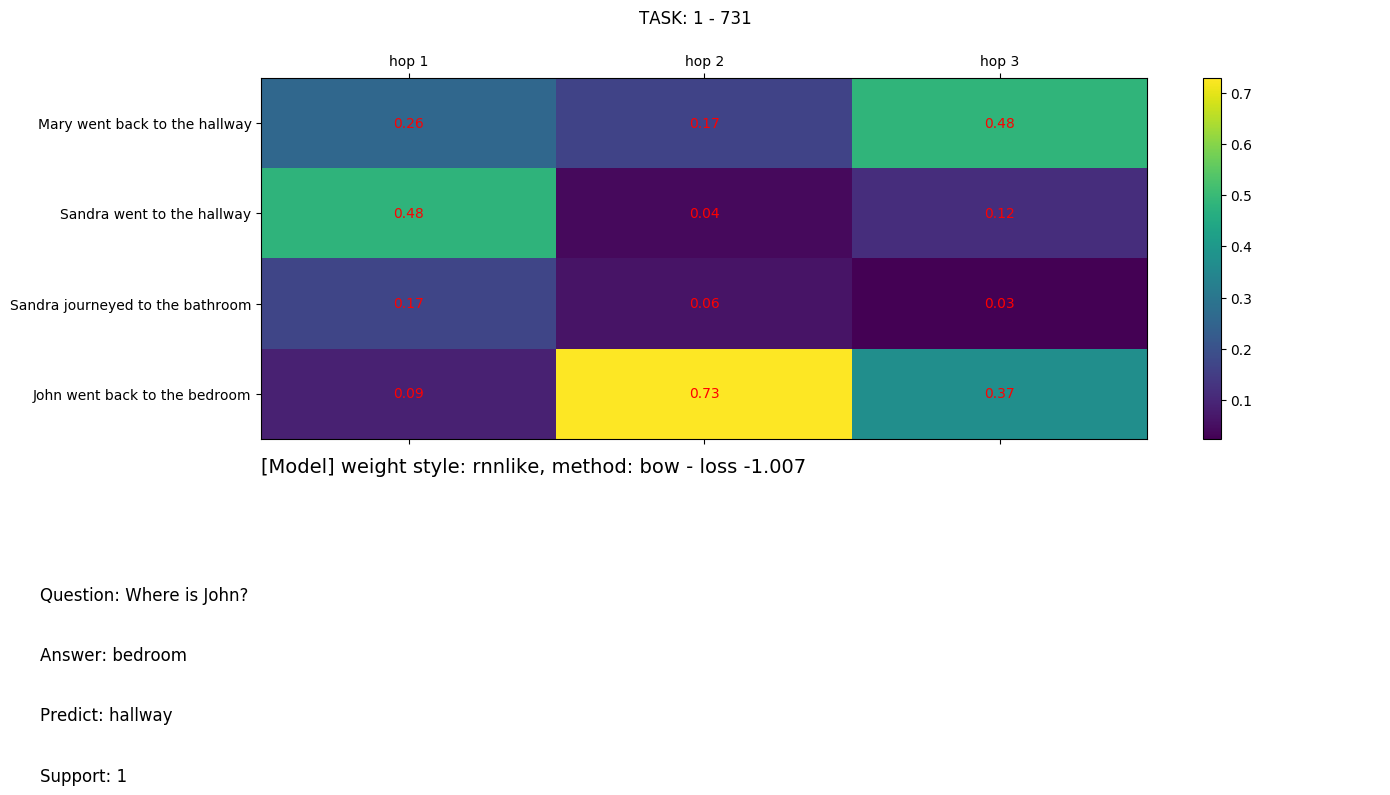

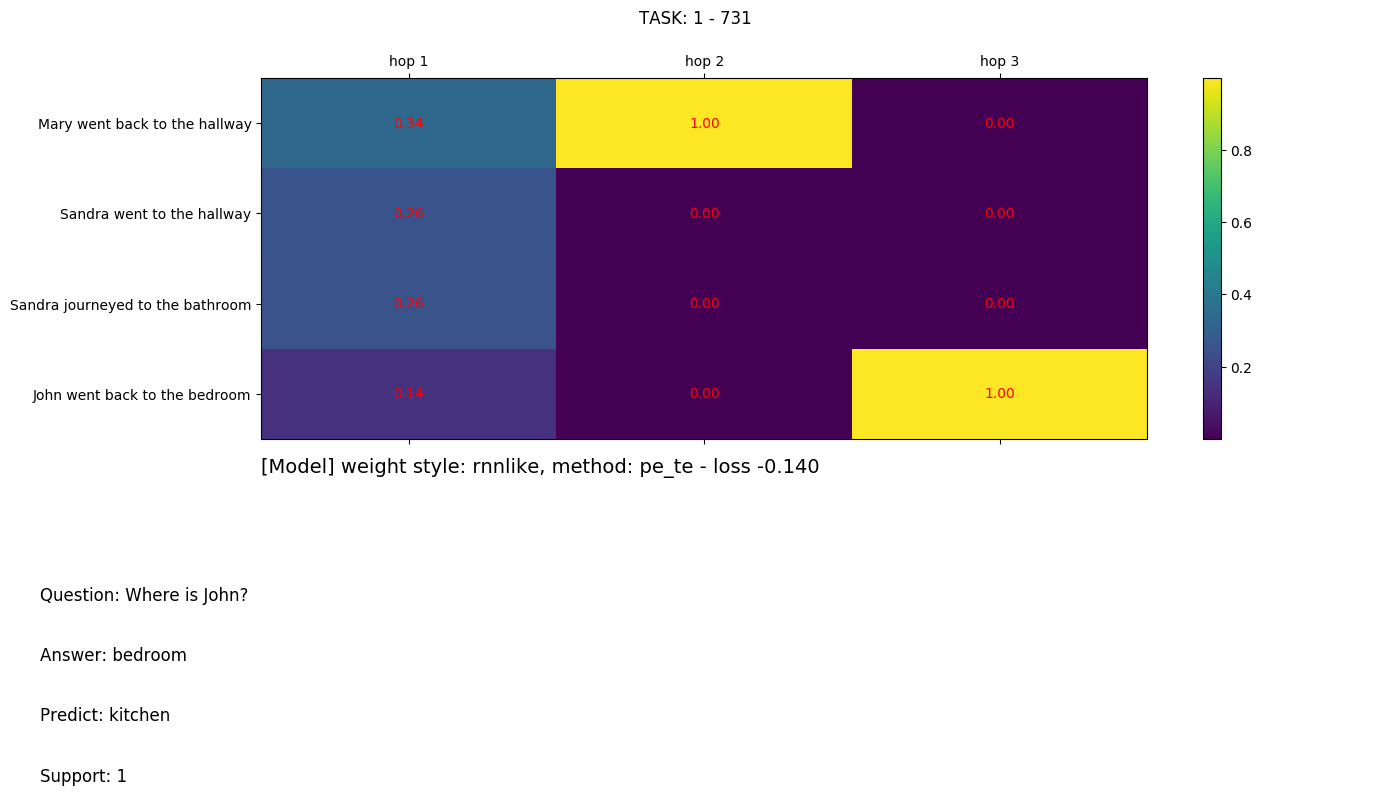

In [13]:
for w_style in weight_styles:
    for method in other_methods:
        test, memn2n, load_path = build_single_model(config, task, w_style, method, device)
        model_name = 'weight style: {}, method: {}'.format(*load_path.split('/')[2:4])
        stories, questions, answers, supports = test.examples[rnd_idx]
        loss, predict_idx, attns = run_single_example(stories, questions, model=memn2n, dataset=test)
        predicts = decode(predict_idx, vocab=test.vocab)
        plot_result(attns, stories, questions, predicts[0], answers[0], supports[0], loss,
                    model_name, task_idx='{} - {}'.format(task, rnd_idx), hops=memn2n.n_hops)